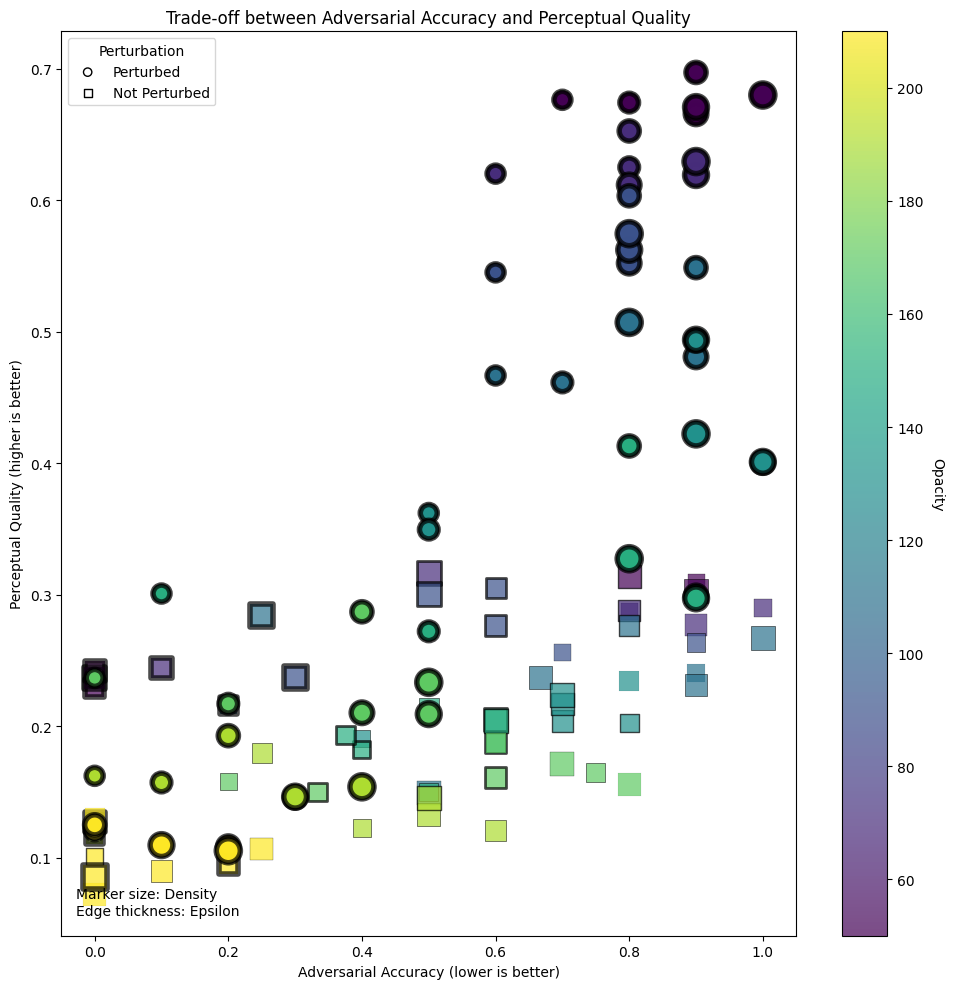

In [51]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from scipy import optimize
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "2-eval_cls_perturb.csv"
data = pd.read_csv(datapath)


"""
preprocessing
"""

data = data.replace([np.inf, -np.inf], np.nan).dropna()
keys = ['opacity', 'density', 'perturb', 'epsilon', 'img_id']
data = data.drop_duplicates(subset=keys)

# difference in accuracy between adversarial and benign examples - we want the performance to decrease relative to what it initially was (lower is better)
data['adv_acc'] = ((data['advx_acc1'] + data['advx_acc5']) / 2) - ((data['x_acc1'] + data['x_acc5']) / 2) + 1
# perceptual quality, approximates human perception (higher is better)
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

# group - get mean of just the 2 inferred metrics
data = data.groupby(['opacity', 'density', 'perturb', 'epsilon']).agg({
    'adv_acc': 'mean',
    'quality': 'mean',
}).reset_index()

data = data.replace([np.inf, -np.inf], np.nan).dropna()
if np.isinf(data['adv_acc']).any() or np.isinf(data['quality']).any():
    print("\nwarning: Infinity values still present in the data")


"""
scatter plot
"""

# "opacity": [50, 70, 90, 110, 130, 150, 170, 190, 210],  # 50;200 is the best
# "density": [50, 60, 70, 80, 90, 100],  # 1;100 same as before
# "perturb": [True, False],
# "epsilon": [0.01, 0.05, 0.1, 0.2, 0.4, 0.8],

plt.figure(figsize=(10, 10))

# Create a colormap for opacity
cmap = plt.cm.viridis

for perturb in [False, True]:
    subset = data[data['perturb'] == perturb]
    
    scatter = plt.scatter(subset['adv_acc'], subset['quality'],
                          c=subset['opacity'], cmap=cmap,
                          s=subset['density'] * 3,
                          marker='o' if perturb else 's',
                          edgecolors='black',
                          linewidths=subset['epsilon'] * 5,
                          alpha=0.7)

# Add colorbar for opacity
cbar = plt.colorbar(scatter)
cbar.set_label('Opacity', rotation=270, labelpad=15)

# Add legend for perturb
plt.scatter([], [], marker='o', edgecolors='black', facecolors='none', label='Perturbed')
plt.scatter([], [], marker='s', edgecolors='black', facecolors='none', label='Not Perturbed')
plt.legend(title='Perturbation', loc='upper left')

# Add text explanation for marker size and edge thickness
plt.text(0.02, 0.02, 'Marker size: Density\nEdge thickness: Epsilon', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Perceptual Quality (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')


plt.tight_layout()
plt.show()

